#Trabajo Final Grupo Nº 2

Rafael Perez	rafaelperezctes@gmail.com
Olinca Ayala	olincayalan88@gmail.com
###@Created on Dec Sat 2 16:57:20 2023
###@author: Grupo Nº 2


# Modulo guias

Este cuaderno realiza la descarga y análisis de secuencias nucleotídicas de integronas de Shewanella utilizando Biopython.


In [1]:
# @title Instalación de librerias
import subprocess
import ipywidgets as widgets
from IPython.display import display
import pkg_resources

def instalar_librerias():
    librerias = [
        "import_ipynb",
        "nbconvert",
        "ipywidgets",
        "biopython",
        "pandas",
        "numpy",
        "matplotlib",
        "tqdm",
        "odfpy",
        "requests",
        "gdown",
        "mafft",
        "clustalo",
        "muscle",
        "fasttree",
        "weblogo",
        "logomaker",

    ]

    barra_progreso = widgets.IntProgress(
        value=0,
        min=0,
        max=len(librerias),
        bar_style='info',
        orientation='horizontal'
    )

    etiqueta = widgets.Label(value='Iniciando instalación...')
    display(widgets.VBox([etiqueta, barra_progreso]))

    # Instalación de fasttree y mafft con apt-get (solo ejecutar en Colab)
    subprocess.run(["apt-get", "install", "fasttree", "mafft", "ghostscript"])

    for libreria in librerias:
        try:
            pkg_resources.require(libreria)
            etiqueta.value = f"{libreria} ya está instalado."
        except pkg_resources.DistributionNotFound:
            etiqueta.value = f"Instalando: {libreria}..."
            subprocess.run(["pip", "install", libreria])
        barra_progreso.value += 1

    etiqueta.value = 'Instalación completada.'
# Crear botón
boton_instalar = widgets.Button(description='Instalar Librerías')

# Crear área de salida
output = widgets.Output()
display(output)

# Enlazar el botón con la función de instalación
boton_instalar.on_click(lambda b: instalar_librerias())

# Mostrar botón
display(boton_instalar)

#instalar_librerias()


Output()

Button(description='Instalar Librerías', style=ButtonStyle())

1. Selección de la Región Objetivo:

- Identifica la región del genoma que deseas editar. Esto podría ser un gen específico o una secuencia de interés.

- Asegúrate de que esta región sea accesible para el sistema CRISPR/Cas9 y no esté oculta o inaccesible en la estructura cromosómica.

2. Diseño de la Secuencia Guía (sgRNA):

- La secuencia guía (sgRNA) debe ser complementaria a la región objetivo en el genoma para guiar la enzima Cas9 al sitio correcto.
- La longitud típica de una sgRNA es de aproximadamente 20 nucleótidos.
Para el sistema CRISPR/Cas9 común (SpCas9), la sgRNA debe estar adyacente a una secuencia PAM (Protospacer Adjacent Motif). Para SpCas9, el PAM es típicamente 'NGG'.
- Evita regiones con alta homología a otras partes del genoma para minimizar los efectos fuera del blanco (off-target effects).

In [2]:
def main():
  instalar_librerias()

if __name__ == "__main__":
    main()


In [5]:
import Bio
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction, MeltingTemp as mt
import pandas as pd

# Variable global para la matriz PAM
PAM_SEQUENCE = 'GG'

# Función para leer secuencias desde archivos FASTA
def read_fasta_files(file_list):
    sequences = {}
    for file in file_list:
        with open(file, "r") as fasta_file:
            for record in SeqIO.parse(fasta_file, "fasta"):
                sequences[file] = str(record.seq)
    return sequences

# Función para generar guías de ARN para CRISPR-Cas9
def generate_guides(dna_seq, pam_sequence=PAM_SEQUENCE):
    guides = []
    for i in range(len(dna_seq) - 22):
        seq = dna_seq[i:i+23]
        if seq.endswith(pam_sequence):
            guide = seq[:20]
            guides.append(guide)
    return guides

# Función para evaluar eficiencia de corte y especificidad de las guías
def score_guides(guides, dna_seq):
    scored_guides = []
    for guide in guides:
        gc_content = gc_fraction(Bio.Seq.Seq(guide)) * 100  # Usando gc_fraction
        tm = mt.Tm_NN(Bio.Seq.Seq(guide))
        poly_t = guide.count('TTTT')
        specificity = dna_seq.count(guide) == 1
        score = (gc_content / 100 * 40) + (tm / 85 * 60) - (poly_t * 5) + (specificity * 20)
        scored_guides.append((guide, score, gc_content, tm, specificity))
    return scored_guides

# Función para seleccionar las mejores guías según su puntuación
def select_best_guides(scored_guides):
    return sorted(scored_guides, key=lambda x: x[1], reverse=True)[:10]

# Función para seleccionar las mejores guías según su puntuación
def process_fasta_files(file_list):
    sequences = read_fasta_files(file_list)
    all_guides_df = pd.DataFrame()

    for file, seq in sequences.items():
        guides = generate_guides(seq)
        scored_guides = score_guides(guides, seq)
        best_guides = select_best_guides(scored_guides)

        # Crear DataFrame para las guías
        guides_df = pd.DataFrame(best_guides, columns=['Guide', 'Score', 'GC%', 'Tm', 'Specificity'])
        guides_df['File'] = file

        # Agregar la fila separadora
        separator = pd.DataFrame([["-"*20, "-"*5, "-"*5, "-"*5, "-"*5, ""]], columns=guides_df.columns)

        # Usar pandas.concat en lugar de DataFrame.append
        all_guides_df = pd.concat([all_guides_df, guides_df, separator], ignore_index=True)

    # Eliminar la última fila separadora
    return all_guides_df.iloc[:-1]


#guides_table = process_fasta_files(['U12441.2.fasta', 'AY509004.fasta'])
#guides_table


,Guide,Score,GC%,Tm,Specificity,File
0,CGCCGCTGCGGCCCTCGGCC,105.400507,90.0,69.984051,True,U12441.2.fasta
1,TCGCCGCCGACGCCCGTGCC,102.916861,85.0,69.298886,True,U12441.2.fasta
2,GGCAAGCGCCGCGACGGCCG,102.468448,85.0,68.663635,True,U12441.2.fasta
3,CCCCGCCGGCGCTGTCACCG,101.540696,85.0,67.349319,True,U12441.2.fasta
4,CGCCCGCCTGGGACGTCGCG,101.519146,85.0,67.318791,True,U12441.2.fasta
5,GGCCGCCCGCTAGCGGACCC,101.050283,85.0,66.654568,True,U12441.2.fasta
6,GTCGGGGTGGGACGGGCCCG,100.579747,85.0,65.987974,True,U12441.2.fasta
7,CGCAACGCCGCTGCGGCCCT,99.911416,80.0,67.874505,True,U12441.2.fasta
8,ATCGCCGCCGACGCCCGTGC,99.549289,80.0,67.361492,True,U12441.2.fasta
9,CCGCCATGCCGCGCGAACGC,99.29613,80.0,67.002851,True,U12441.2.fasta


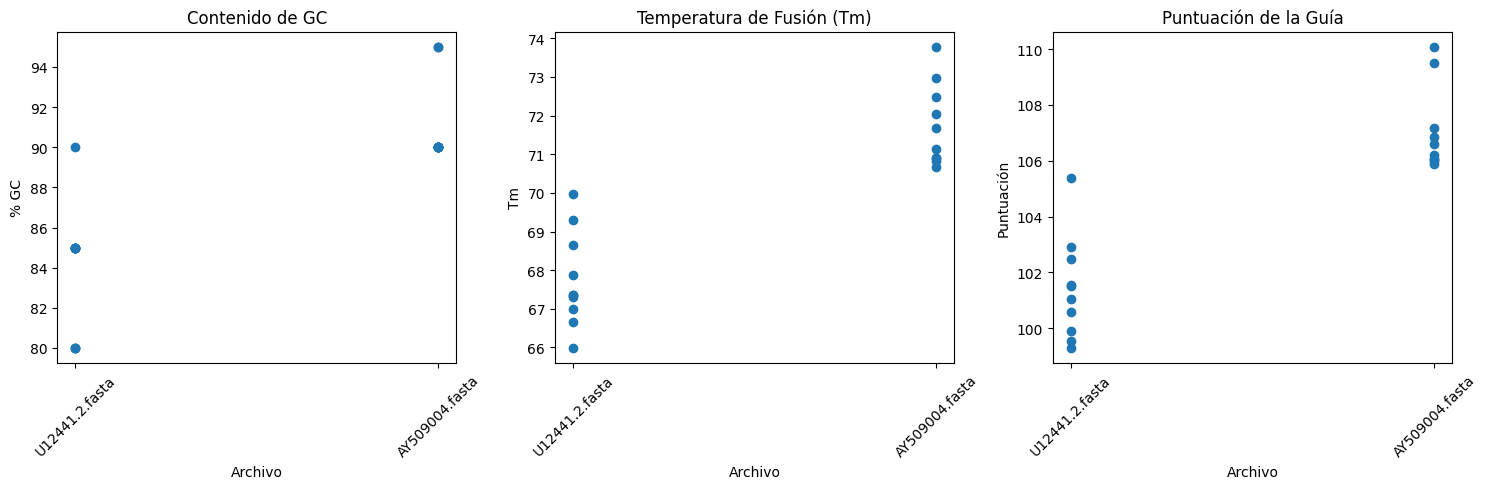

In [8]:
import matplotlib.pyplot as plt

# Suponiendo que 'all_guides_df' es el DataFrame resultante de tu función 'process_fasta_files'
#all_guides_df = process_fasta_files(['U12441.2.fasta', 'AY509004.fasta'])  # Ejemplo de llamada a la función

def plot_guide_comparisons(df):
    # Filtrar las filas que no son guías de ARN (es decir, las filas de separación)
    df_filtered = df[df['Guide'].apply(lambda x: x.isalpha())]

    # Crear subplots para cada característica
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    # Contenido de GC
    axes[0].scatter(df_filtered['File'], df_filtered['GC%'])
    axes[0].set_title('Contenido de GC')
    axes[0].set_xlabel('Archivo')
    axes[0].set_ylabel('% GC')
    axes[0].tick_params(axis='x', rotation=45)

    # Temperatura de fusión (Tm)
    axes[1].scatter(df_filtered['File'], df_filtered['Tm'])
    axes[1].set_title('Temperatura de Fusión (Tm)')
    axes[1].set_xlabel('Archivo')
    axes[1].set_ylabel('Tm')
    axes[1].tick_params(axis='x', rotation=45)

    # Puntuación
    axes[2].scatter(df_filtered['File'], df_filtered['Score'])
    axes[2].set_title('Puntuación de la Guía')
    axes[2].set_xlabel('Archivo')
    axes[2].set_ylabel('Puntuación')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#plot_guide_comparisons(all_guides_df)



In [6]:

import random
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import matplotlib.pyplot as plt

# Función para transformar bacterias simulando ediciones CRISPR/Cas9
def transform_bacteria(guides, sequence):
    mutations = []
    for guide in guides:
        if random.random() < 0.5:  # 50% de posibilidades de una edición exitosa
            start = sequence.find(guide)
            if start != -1:
                end = start + len(guide)
                mutation_type = random.choice(["deletion", "insertion", "substitution"])
                if mutation_type == "deletion":
                    sequence = sequence[:start] + sequence[end:]
                    mutations.append((mutation_type, start, sequence[start:end], ""))
                elif mutation_type == "insertion":
                    insertion_seq = "ATCG"
                    sequence = sequence[:start] + insertion_seq + sequence[start:]
                    mutations.append((mutation_type, start, "", insertion_seq))
                elif mutation_type == "substitution":
                    substitution_seq = "ATCG"
                    sequence = sequence[:start] + substitution_seq + sequence[end:]
                    mutations.append((mutation_type, start, sequence[start:end], substitution_seq))
    return sequence, mutations

# Función para verificar la edición genética
def verify_editing(accession_number, original_sequence, edited_sequence, mutations):
    if original_sequence != edited_sequence:
        print(f"Edición genética verificada para {accession_number}")
        summarize_mutations(mutations)
        graphical_representation(original_sequence, edited_sequence, mutations)
        plot_sequence_differences(original_sequence, edited_sequence, mutations)
        return edited_sequence
    else:
        print(f"No se detectó edición genética para {accession_number}")
        return None

# Función para resumir las mutaciones
def summarize_mutations(mutations):
    print(f"\nTotal de mutaciones: {len(mutations)}")
    count_deletion = sum(1 for m in mutations if m[0] == "deletion")
    count_insertion = sum(1 for m in mutations if m[0] == "insertion")
    count_substitution = sum(1 for m in mutations if m[0] == "substitution")

    print(f"Deleciones: {count_deletion}")
    print(f"Inserciones: {count_insertion}")
    print(f"Sustituciones: {count_substitution}")

# Función para representación gráfica de las ediciones
def graphical_representation(original_seq, edited_seq, mutations):
    print("\nOriginal: " + original_seq[:50] + "..." + original_seq[-50:])
    print("Editada : " + edited_seq[:50] + "..." + edited_seq[-50:])
    for mutation in mutations:
        mutation_type, position, original, new = mutation
        print(f"{'^' * len(original)} {mutation_type.capitalize()} en posición {position}")

# Función para graficar las diferencias de secuencias
def plot_sequence_differences(original_seq, edited_seq, mutations):
    positions = [pos for _, pos, _, _ in mutations]
    mutation_types = [mut_type for mut_type, _, _, _ in mutations]

    plt.figure(figsize=(10, 3))
    plt.scatter(positions, [1] * len(positions), c='red', label='Mutaciones')
    for pos, mut_type in zip(positions, mutation_types):
        plt.annotate(mut_type, (pos, 1), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title('Distribución de Mutaciones en la Secuencia')
    plt.xlabel('Posición en la Secuencia')
    plt.yticks([])
    plt.legend()
    plt.show()

# Ejemplo de uso
accession_number = "NC_016848.1"
#with open(accession_number + ".fasta", "r") as file:
#    original_sequence = SeqIO.read(file, "fasta").seq

guides = ["GTTACG", "CGTACG"]  # Ejemplo de guías CRISPR
#edited_sequence, mutations = transform_bacteria(guides, original_sequence)

#edited_seq_record = verify_editing(accession_number, original_sequence, edited_sequence, mutations)
#if edited_seq_record:
#    SeqIO.write(SeqRecord(Seq(edited_seq_record), id=accession_number), f"{accession_number}_edited.fasta", "fasta")
